<center>

# Handwriting Tickets OCR
*github/cloudy-sfu*

</center>

This repository shows how to recognizing tables with Chinese characters and numbers in handwriting tickets.

Import packages.

In [1]:
import os
import pickle
from itertools import count
import cv2
import numpy as np
import pandas as pd
import pypdfium2 as pdfium
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import matplotlib.pyplot as plt
from openvino.inference_engine import IECore
from lstm_rnn_ctc.ctccodec import CtcCodec
from threading import Thread

/home/cld/.conda/envs/ocr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cld/.conda/envs/ocr/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2023-04-13 14:01:26 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


Input scanned tickets to recognize.

In [2]:
filename = "data/style1.pdf" #@param ["data/style1.pdf", "data/style2.pdf", "data/style3.pdf"] {allow-input: true}
name = os.path.splitext(os.path.split(filename)[1])[0]

# Table layout

Convert PDF to image.

In [3]:
pdf = pdfium.PdfDocument(filename)
# https://pypdfium2.readthedocs.io/en/stable/python_api.html#pypdfium2._helpers.page.PdfPage.render_base
n_pages = len(pdf)
pages_generator = pdf.render_to(pdfium.BitmapConv.numpy_ndarray, page_indices=range(n_pages),
                             scale=300 / 72, greyscale=True)  # scale unit: 72 dpi

Use a counter to generate page numbers.

In [4]:
page_number_generator = count()
cells = []

Analyze page layouts.

In [5]:
with open(f'raw/{name}_tables.pkl', 'wb') as f:
    for page, channel in pages_generator:
        page_number = next(page_number_generator)  # counter from 0
        # Flush the same line:
        # use `print()` to start a new line, giving space to the first "cursor up" command, before the loop
        # use the suffix `\x1b[1A\x1b[2K` in each print to move the cursor up and clean the line
        # if the string length monotonically increase in each iteration, we simplify this version as the following
        print(f'\rAnalyzing page {page_number + 1}/{n_pages}.', end='')

        reversed_page = cv2.bitwise_not(page[:, :, 0])  # conver to black background
        # significantly faster than cv2.RETR_TREE
        # extracting subtree from a hierarchy unsolved -> use cv2.RETR_EXTERNAL insteead of cv2.RETR_TREE
        # not analyzing hierarchy inside the table in this function
        contours, hierarchy = cv2.findContours(reversed_page, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        size = [cv2.contourArea(x) for x in contours]  # Slightly faster than np.vectorize but not significant
        largest_outer_contour = contours[np.argmax(size)]
        # automatically rotate the table
        # https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
        box = cv2.minAreaRect(largest_outer_contour)
        w, h = box[1]
        source_points = cv2.boxPoints(box)
        if box[2] > 45:  # (45, 90) left is lower and right is higher
            destination_points = np.array([[0, 0], [h, 0], [h, w], [0, w]])
            transformation = cv2.getPerspectiveTransform(source_points.astype('float32'),
                                                        destination_points.astype('float32'))
            rotated_table = cv2.warpPerspective(reversed_page, transformation, (int(h), int(w)))
        else:  # (0, 45) left is higher and right is lower
            destination_points = np.array([[0, h], [0, 0], [w, 0], [w, h]])
            transformation = cv2.getPerspectiveTransform(source_points.astype('float32'),
                                                        destination_points.astype('float32'))
            rotated_table = cv2.warpPerspective(reversed_page, transformation, (int(w), int(h)))
        pickle.dump(rotated_table, f)

        contours, hierarchy = cv2.findContours(rotated_table, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        h, w = rotated_table.shape
        sq_lb, sq_ub = max(784, h * w * 6e-4), h * w * 0.9
        positions = np.array([cv2.boundingRect(x) for x in contours if sq_lb < cv2.contourArea(x) < sq_ub])
        # when contourArea > sq_lb, cell w*h > sq_lb w.p.1
        positions = positions[positions[:, 2] * positions[:, 3] < sq_ub, :]
        cells_per_table = pd.DataFrame(columns=['x', 'y', 'w', 'h'], data=positions)
        cells_per_table['table_id'] = page_number
        cells_per_table['table_w'] = w
        cells_per_table['table_h'] = h

        cells.append(cells_per_table)

Analyzing page 168/168.

In [6]:
cells = pd.concat(cells)

# Cell correspondence



In [7]:
positions = pd.DataFrame({
    'relative_x': cells['x'] / cells['table_w'],
    'relative_y': cells['y'] / cells['table_h']
})
n_tables = cells['table_id'].max() + 1
min_pts = int(n_tables * 0.4)

# empirical method
relative_w = cells['w'] / cells['table_w']
relative_h = cells['h'] / cells['table_h']
eps = np.sqrt(relative_w.min() ** 2 + relative_h.min() ** 2) * 1.22475

dbscan = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1)
cells['labels'] = dbscan.fit_predict(positions)
cells = cells.loc[cells['labels'] != -1, :]
cells_labeled = cells.drop_duplicates(subset=['table_id', 'labels'])

In [8]:
n_tables = cells_labeled['table_id'].max() + 1
cells_subtotals = []
for (label, cells_subset) in cells_labeled.groupby('labels'):
    cells_subtotals.append({
        'label': label + 1,
        'frequency': cells_subset.shape[0] / n_tables,
        'avg_relative_x': (cells_subset['x'] / cells_subset['table_w']).mean(),
        'avg_relative_y': (cells_subset['y'] / cells_subset['table_h']).mean(),
        'avg_relative_w': (cells_subset['w'] / cells_subset['table_w']).mean(),
        'avg_relative_h': (cells_subset['h'] / cells_subset['table_h']).mean(),
    })
anchors = pd.DataFrame(cells_subtotals)

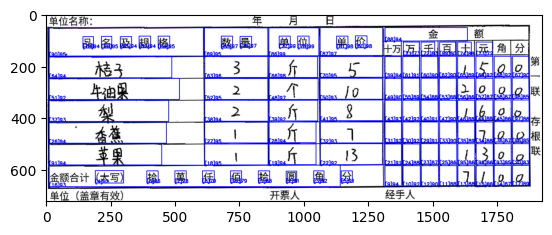

In [9]:
with open(f"raw/{name}_tables.pkl", "rb") as f:
    table = pickle.load(f)
table = cv2.bitwise_not(table)
table = cv2.cvtColor(table[:, :, np.newaxis], cv2.COLOR_GRAY2RGB)
h, w, _ = table.shape
border_width = int(max(min(h / 540, w / 540), 2))
for _, anchor in anchors.iterrows():
    x1 = int(anchor['avg_relative_x'] * w)
    y1 = int(anchor['avg_relative_y'] * h)
    x2 = x1 + int(anchor['avg_relative_w'] * w)
    y2 = y1 + int(anchor['avg_relative_h'] * h)
    cv2.rectangle(table, (x1, y1), (x2, y2), (0, 0, 255), border_width)  # BGR
    # https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
    cv2.putText(table, f"[{int(anchor['label'])}]{int(anchor['frequency'] * 100)}",
                org=(x1, y2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 0, 255),  # BGR
                thickness=border_width)
plt.imshow(table)
plt.show()

# Table OCR
Perform handwriting Chinese OCR of the tables.

In [10]:
model_xml = 'intel/handwritten-simplified-chinese-recognition-0001/FP16-INT8/handwritten-simplified-chinese' \
            '-recognition-0001.xml'
model_bin = 'intel/handwritten-simplified-chinese-recognition-0001/FP16-INT8/handwritten-simplified-chinese' \
            '-recognition-0001.bin'
# Prepare the language specific information, characters list and codec method
chars_list_file = 'lstm_rnn_ctc/scut_ept.txt'
with open(chars_list_file, 'r') as f:
    model_characters = f.read()
codec = CtcCodec(model_characters)
ie = IECore()  # Plugin initialization for specified device and load extensions library if specified
net = ie.read_network(model=model_xml, weights=model_bin)  # Read OpenVino IR model
net_exec = ie.load_network(network=net, device_name='CPU')
_, _, net_h, net_w = net.input_info['actual_input'].input_data.shape

In [11]:
text = pd.DataFrame(index=np.arange(n_pages), columns=anchors['label'].values)
progress_bar = tqdm(total=text.shape[0] * text.shape[1])
progress_bar.n = 0
class OCR(Thread):
    def __init__(self, table_id, table):
        self.table_id = table_id
        self.table = table
        Thread.__init__(self)
    
    def run(self):
        for i in range(anchors.shape[0]):
            cell = self.table[y[i]:y[i] + h[i], x[i]:x[i] + w[i]]
            
            # this part is applicable when text alignment is horizontal
            cell_h, cell_w = cell.shape
            # when slimmer than the requirement of model, keep the aspect ratio and pad white
            adjusted_cell_w = int(cell_w / cell_h * net_h)
            if adjusted_cell_w <= net_w:
                processed_cell = np.full((net_h, net_w), 255)
                processed_cell[:, :adjusted_cell_w] = cv2.resize(cell, (adjusted_cell_w, net_h), interpolation=cv2.INTER_AREA)
            # when wider than the requirement of model,
            else:
                processed_cell = cv2.resize(cell, (net_w, net_h), interpolation=cv2.INTER_AREA)
            processed_cell = processed_cell[np.newaxis, np.newaxis, :, :]  
            res = net_exec.infer(inputs={'actual_input': processed_cell})
            res_decoded = codec.decode(res['output'])
            text.loc[self.table_id, anchors.loc[i, 'label']] = ''.join(res_decoded)
            
            progress_bar.update(1)

  0%|                                                                          | 0/16632 [00:00<?, ?it/s]

In [ ]:
batch_size = 32
n_batch = n_pages // batch_size + 1
with open(f'raw/{name}_tables.pkl', 'rb') as f:
    for b in range(n_batch):
        ocr = []
        if b < n_batch - 1:
            j_list = (b * batch_size, (b+1) * batch_size)
        else:
            j_list = (b * batch_size, n_pages)
        for j in range(*j_list):
            table = pickle.load(f)

            tb_h, tb_w = table.shape
            x = np.round(anchors['avg_relative_x'].values * tb_w).astype(int)
            y = np.round(anchors['avg_relative_y'].values * tb_h).astype(int)
            w = np.round(anchors['avg_relative_w'].values * tb_w).astype(int)
            h = np.round(anchors['avg_relative_h'].values * tb_h).astype(int)
            table = cv2.bitwise_not(table)  # convert to white background
            
            ocr_task = OCR(table_id=b * batch_size + j, table=table)
            ocr_task.start()
            ocr.append(ocr_task)
        [ocr_task.join() for ocr_task in ocr]
text

  1%|▌                                                             | 142/16632 [00:11<6:07:22,  1.34s/it]

In [ ]:
text.to_excel(f'results/{name}_text.xlsx', index=False)